In [4]:
import pandas as pd
from IPython.display import display, HTML
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [5]:
def display_scrollable_df(df, max_rows=5, height=300):
    display(HTML(df.head(max_rows).to_html(max_rows=max_rows, max_cols=100, escape=False)))
    display(HTML(f"""<style>
        .output_scroll {{
            max-height: {height}px;
            overflow-y: auto;
        }}
    </style>"""))

In [6]:
# Load Dataset - World Stock Prices (Daily Updating)
world_path = r"C:\Users\anitr\AAI510_Group6Project\AAI510_Group6Project\World Stock Prices (Daily Updating)\World-Stock-Prices-Dataset.csv"

df = pd.read_csv(world_path)

print("World Stock Prices Dataset:")
display_scrollable_df(df)

World Stock Prices Dataset:


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Brand_Name,Ticker,Industry_Tag,Country,Capital Gains
0,2025-05-30 00:00:00-04:00,7.020000,7.240000,6.920000,7.100000,12750600.0,0.0,0.0,peloton,PTON,fitness,usa,NaN
1,2025-05-30 00:00:00-04:00,102.639999,102.940002,100.790001,102.000000,1505500.0,0.0,0.0,crocs,CROX,footwear,usa,NaN
2,2025-05-30 00:00:00-04:00,71.610001,72.470001,71.610001,72.099998,28013500.0,0.0,0.0,the coca-cola company,KO,food & beverage,usa,NaN
3,2025-05-30 00:00:00-04:00,125.080002,126.190002,123.750000,124.510002,82500.0,0.0,0.0,adidas,ADDYY,apparel,germany,NaN
4,2025-05-30 00:00:00-04:00,294.970001,295.750000,291.630005,294.049988,5251700.0,0.0,0.0,american express,AXP,finance,usa,NaN


In [7]:
df.dtypes

Date              object
Open             float64
High             float64
Low              float64
Close            float64
Volume           float64
Dividends        float64
Stock Splits     float64
Brand_Name        object
Ticker            object
Industry_Tag      object
Country           object
Capital Gains    float64
dtype: object

In [8]:
df['Date'] = pd.to_datetime(df['Date'], utc=True)

In [9]:
df.dtypes

Date             datetime64[ns, UTC]
Open                         float64
High                         float64
Low                          float64
Close                        float64
Volume                       float64
Dividends                    float64
Stock Splits                 float64
Brand_Name                    object
Ticker                        object
Industry_Tag                  object
Country                       object
Capital Gains                float64
dtype: object

In [10]:
df_filtered = df.copy()
df_filtered = df_filtered[df_filtered["Country"] == "usa"]
df_filtered = df_filtered.drop(['Brand_Name', 'Capital Gains', 'Country', 'Industry_Tag', 'Stock Splits', 'Dividends'], axis=1)
df_filtered.head()

,Date,Open,High,Low,Close,Volume,Ticker
0,2025-05-30 04:00:00+00:00,7.020000,7.240000,6.920000,7.100000,12750600.0,PTON
1,2025-05-30 04:00:00+00:00,102.639999,102.940002,100.790001,102.000000,1505500.0,CROX
2,2025-05-30 04:00:00+00:00,71.610001,72.470001,71.610001,72.099998,28013500.0,KO
4,2025-05-30 04:00:00+00:00,294.970001,295.750000,291.630005,294.049988,5251700.0,AXP
6,2025-05-30 04:00:00+00:00,361.350006,367.040009,361.350006,365.190002,8726000.0,V


In [11]:
df_filtered.set_index('Date', inplace=True)
df_filtered.head()

,Open,High,Low,Close,Volume,Ticker
Date,,,,,,
2025-05-30 04:00:00+00:00,7.020000,7.240000,6.920000,7.100000,12750600.0,PTON
2025-05-30 04:00:00+00:00,102.639999,102.940002,100.790001,102.000000,1505500.0,CROX
2025-05-30 04:00:00+00:00,71.610001,72.470001,71.610001,72.099998,28013500.0,KO
2025-05-30 04:00:00+00:00,294.970001,295.750000,291.630005,294.049988,5251700.0,AXP
2025-05-30 04:00:00+00:00,361.350006,367.040009,361.350006,365.190002,8726000.0,V


In [12]:
df_filtered.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
Ticker    0
dtype: int64

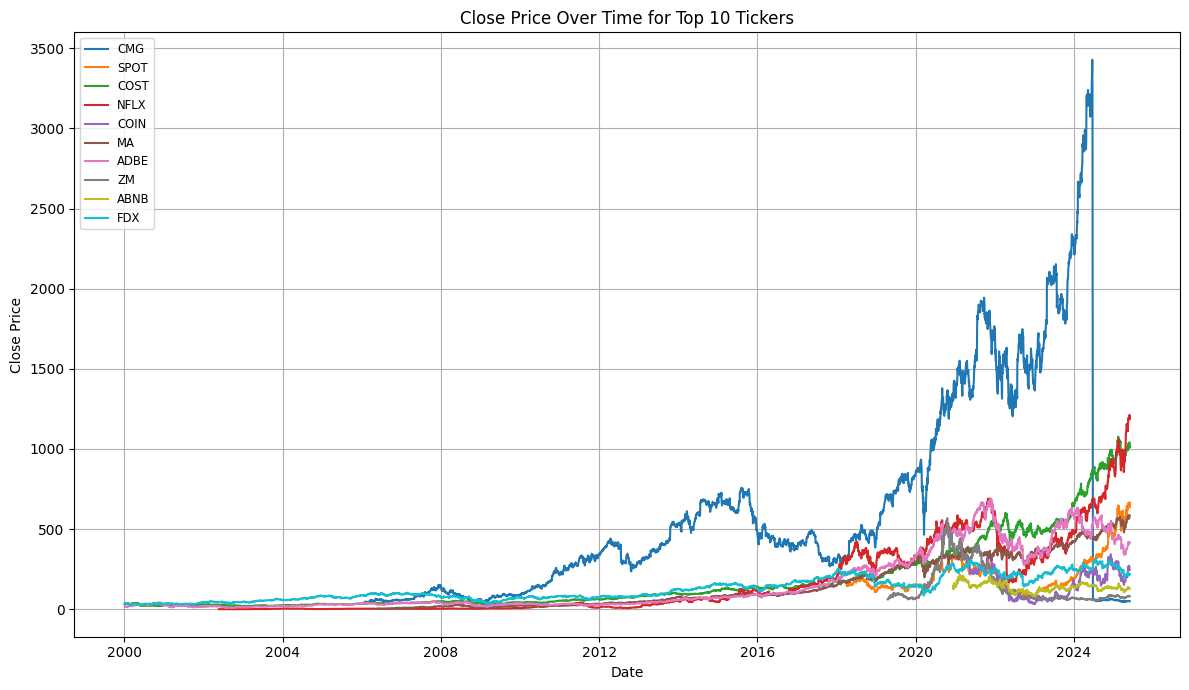

In [13]:
top_tickers = (
    df_filtered.groupby("Ticker")["Close"]
    .mean()
    .nlargest(10)
    .index
)

plt.figure(figsize=(12, 7))
for ticker in top_tickers:
    df_ticker = df_filtered[df_filtered["Ticker"] == ticker]
    plt.plot(df_ticker.index, df_ticker["Close"], label=ticker)

plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Close Price Over Time for Top 10 Tickers")
plt.legend(loc="upper left", fontsize="small")
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
df_stock = df_filtered[df_filtered["Ticker"] == "NFLX"].copy()
df_stock = df_stock.sort_index()

In [15]:
df_stock.head()

,Open,High,Low,Close,Volume,Ticker
Date,,,,,,
2002-05-23 04:00:00+00:00,1.156429,1.242857,1.145714,1.196429,104790000.0,NFLX
2002-05-24 04:00:00+00:00,1.214286,1.225000,1.197143,1.210000,11104800.0,NFLX
2002-05-28 04:00:00+00:00,1.213571,1.232143,1.157143,1.157143,6609400.0,NFLX
2002-05-29 04:00:00+00:00,1.164286,1.164286,1.085714,1.103571,6757800.0,NFLX
2002-05-30 04:00:00+00:00,1.107857,1.107857,1.071429,1.071429,10154200.0,NFLX


In [16]:
df_fe = df_stock.copy()

df_fe['Close_lag_1'] = df_fe['Close'].shift(1)

df_fe['Return_1d'] = df_fe['Close'].pct_change()

df_fe['MA_5'] = df_fe['Close'].rolling(window=5).mean()
df_fe['MA_20'] = df_fe['Close'].rolling(window=20).mean()

df_fe['Volatility_10d'] = df_fe['Close'].rolling(window=10).std()

df_fe['Volume_MA_10'] = df_fe['Volume'].rolling(window=10).mean()
df_fe['Volume_Ratio'] = df_fe['Volume'] / df_fe['Volume_MA_10']

df_fe.dropna(inplace=True)
features = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'Close_lag_1', 'Return_1d',
    'MA_5', 'MA_20',
    'Volatility_10d',
    'Volume_Ratio'
]

In [17]:
features = ['Open', 'High', 'Low', 'Close']
df_stock = df_stock[features].dropna().copy()

In [18]:
# Split into train/test (80/20)
train_size = int(len(df_stock) * 0.8)
df_train = df_stock.iloc[:train_size]
df_test = df_stock.iloc[train_size:]

# Fit scaler on train
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(df_train)
scaled_test = scaler.transform(df_test)

# Build DataFrames back from scaled arrays
df_train_scaled = pd.DataFrame(scaled_train, columns=features, index=df_train.index)
df_test_scaled = pd.DataFrame(scaled_test, columns=features, index=df_test.index)

In [19]:
window_size = 20  # use past 20 days

X_train, y_train = [], []

for i in range(window_size, len(df_train_scaled) - 1):
    X_window = df_train_scaled.iloc[i - window_size:i][features].values.flatten()
    y_target = df_train_scaled.iloc[i + 1]['Close']  # next day close
    X_train.append(X_window)
    y_train.append(y_target)

X_train = np.array(X_train)
y_train = np.array(y_train).reshape(-1, 1)

# fit LR model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [20]:
input_window = df_train_scaled.iloc[-window_size:][features].copy()
predicted_sequence = []

for i in range(len(df_test_scaled)):
    X_input = input_window.values.flatten().reshape(1, -1)

    predicted_scaled_close = lr_model.predict(X_input)[0][0]
    predicted_scaled_close = np.clip(predicted_scaled_close, 0, 1)

    # next day real open high low 
    next_day = df_test_scaled.iloc[i][['Open', 'High', 'Low']].copy()

    # Create next input row using predicted Close
    next_input_row = np.append(next_day.values, predicted_scaled_close)
    input_window = pd.concat([
        input_window.iloc[1:],  # drop oldest row
        pd.DataFrame([next_input_row], columns=features)
    ], ignore_index=True)

    predicted_sequence.append(predicted_scaled_close)

Rolling Forecast MSE: 50077.60
Rolling Forecast R²: 0.0354


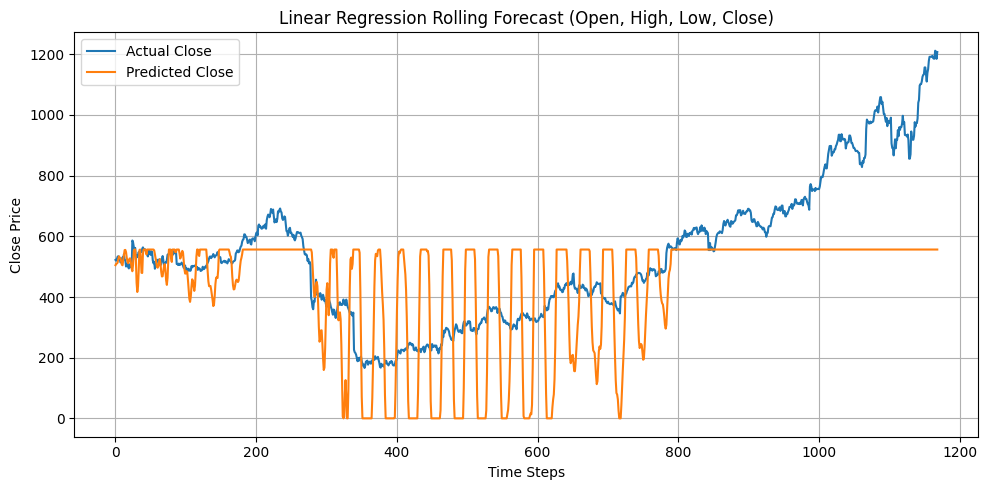

In [21]:
# replace close with values so we can inverse transform
df_pred_scaled = df_test_scaled.copy()
df_pred_scaled['Close'] = predicted_sequence

# inverse transform
predicted_actual = scaler.inverse_transform(df_pred_scaled)[:, features.index('Close')]
actual_closes = df_test['Close'].values[:len(predicted_actual)]

mse = mean_squared_error(actual_closes, predicted_actual)
r2 = r2_score(actual_closes, predicted_actual)
print(f"Rolling Forecast MSE: {mse:.2f}")
print(f"Rolling Forecast R²: {r2:.4f}")
plt.figure(figsize=(10, 5))
plt.plot(actual_closes, label='Actual Close')
plt.plot(predicted_actual, label='Predicted Close')
plt.title("Linear Regression Rolling Forecast (Open, High, Low, Close)")
plt.xlabel("Time Steps")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
# Calculate MAE and RMSE
mae = np.mean(np.abs(actual_closes - predicted_actual))
rmse = np.sqrt(np.mean((actual_closes - predicted_actual) ** 2))
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


Mean Absolute Error (MAE): 175.6256
Root Mean Squared Error (RMSE): 223.7803
